## Install Seisbench

In [1]:
!pip install seisbench

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task1.csv

--2022-09-15 06:38:40--  https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task1.csv
Resolving dcache-demo.desy.de (dcache-demo.desy.de)... 131.169.191.70, 2001:638:700:10bf::1:46
Connecting to dcache-demo.desy.de (dcache-demo.desy.de)|131.169.191.70|:2443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4272225 (4.1M) [text/csv]
Saving to: ‘task1.csv’

task1.csv           100%[===================>]   4.07M  4.66MB/s    in 0.9s    

2022-09-15 06:38:42 (4.66 MB/s) - ‘task1.csv’ saved [4272225/4272225]



In [3]:
!wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task23.csv

--2022-09-15 06:38:42--  https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task23.csv
Resolving dcache-demo.desy.de (dcache-demo.desy.de)... 131.169.191.70, 2001:638:700:10bf::1:46
Connecting to dcache-demo.desy.de (dcache-demo.desy.de)|131.169.191.70|:2443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3351647 (3.2M) [text/csv]
Saving to: ‘task23.csv’

task23.csv          100%[===================>]   3.20M  3.68MB/s    in 0.9s    

2022-09-15 06:38:44 (3.68 MB/s) - ‘task23.csv’ saved [3351647/3351647]



In [4]:
import pandas as pd
targets_task1 = pd.read_csv('task1.csv')
targets_task23 = pd.read_csv('task23.csv')

In [5]:
!mkdir targets
!mkdir targets/ethz
!mv *.csv targets/ethz

## Imports

In [6]:
# seisbench
import seisbench
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
#plotting
import matplotlib.pyplot as plt

#torch and numpy
import numpy as np
import torch
from torch.utils.data import DataLoader 

## Init Dataset - Downloading if needed 

For the first trial we shall use ETHZ dataset.

 The ETHZ benchmark dataset contains regional recorded seismicity on publicly available networks throughout the Switzerland region. For more information see: [SED website](http://www.seismo.ethz.ch/en/research-and-teaching/products-software/waveform-data/).

ETHZ Dataset contains 36,743 waveform examples.

*About 22GB of data is going to be downloaded. Be patient!*

In [7]:
# Take only test data
ethz_data = sbd.ETHZ(sampling_rate=100, force=True).test()
print(ethz_data)

2022-09-15 06:38:58,729 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2022-09-15 06:38:59,540 | seisbench | WARNING | Dataset ETHZ not in cache.
2022-09-15 06:38:59,547 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.


ETHZ - 10485 traces


## Examine Dataset

Number of examples: 10485
Example: {'X': array([[  67.21280202,   47.885615  ,   53.11455932, ...,  235.87955613,
         225.48567639,  213.64320158],
       [-133.15287419, -139.28803171, -134.72644495, ..., -229.29890926,
        -226.96676084, -212.00536781],
       [ 136.70016655,  124.08178188,  117.09740703, ..., -170.6999382 ,
        -190.71496976, -216.97710333]])}


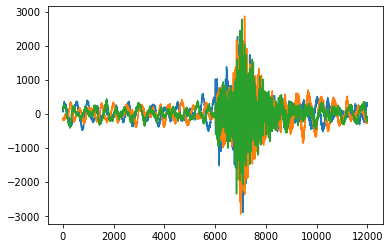

In [ ]:
#@title Select Trace Number
# If you are not in Colab choose trace number by typing
trace_number = 3412 #@param {type:"slider", min:0, max:10485, step:1}
trace_number = int(trace_number)
assert 0 <= trace_number <= 10485
generator = sbg.GenericGenerator(ethz_data)
print("Number of examples:", len(generator))

sample = generator[trace_number]
print("Example:", sample)
plt.plot(sample["X"].T);

In [ ]:
ethz_data.metadata.columns

Index(['source_id', 'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude_deg', 'source_latitude_uncertainty_km',
       'source_longitude_deg', 'source_longitude_uncertainty_km',
       'source_depth_km', 'source_depth_uncertainty_km', 'split',
       'source_magnitude', 'source_magnitude_uncertainty',
       'source_magnitude_type', 'source_magnitude_author',
       'path_back_azimuth_deg', 'station_network_code', 'station_code',
       'trace_channel', 'station_location_code', 'station_latitude_deg',
       'station_longitude_deg', 'station_elevation_m', 'trace_name',
       'trace_sampling_rate_hz', 'trace_completeness', 'trace_has_spikes',
       'trace_start_time', 'trace_S1_arrival_sample', 'trace_S1_status',
       'trace_S1_polarity', 'trace_name_original', 'trace_P1_arrival_sample',
       'trace_P1_status', 'trace_P1_polarity', 'trace_Pg_arrival_sample',
       'trace_Pg_status', 'trace_Pg_polarity', 'trace_Sg_arrival_sample',
       'trace_Sg_status

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##Save a noise segment

The first 3001 samples of the dataset are assumed to be noise. Save it as a real natural noise to be added  to traces in order to check model robustness.

(3, 3001) 4.470914948471468


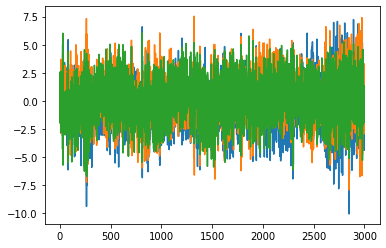

In [ ]:
noise_trace = generator[0]['X'][:,2700:(2700+3001)]
noise_energy = np.mean(np.square(noise_trace)) 
print(noise_trace.shape, noise_energy)
plt.plot(noise_trace.T)

In [ ]:
noise_trace.shape

(3, 3001)

## Add Augmentation

The following dictionart is needed because of the "too much information" given by the ETHZ dataset about the phases.  We only want to differentiate between P and S picks.


In [ ]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

~~Define and add augmentations.
We take a window around an event, 27 seconds before the event and 7  seconds after it, and crop a random window of 30 seconds hence it will have at least 23 seconds before the event and at least 3 seconds after it.~~

~~The second important augmentation is the labeler. In this context it is just needed to have some label. Not sure that this is the right way. ???~~

**This generator is commented out for the sake of using the steered generator.**

In [ ]:
# generator = sbg.GenericGenerator(ethz_data)


# augmentations = [
#     sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=2700, windowlen=3400, selection="random", strategy="pad", key=('X', 'SNR')),
#     sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
#     sbg.RandomWindow(windowlen=3001, strategy="pad"),
#     sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
#     sbg.ChangeDtype(np.float32),
#     sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
# ]
# generator.add_augmentations(augmentations)

# @generator.augmentation
# def print_state_dict(state_dict):
#   # print(state_dict)
#   state_dict['ddd'] = (5, 1)

# # @generator.augmentation
# # def print_state_dict(phase_dict):
# #     print(phase_dict)


# generator[0]['ddd']


# genera


In [ ]:
gen  = sbg.SteeredGenerator(ethz_data, targets_task23[targets_task23.phase_label == 'P'])

#@gen.augmentation
#def print_state_dict(state_dict):
#  print(state_dict['_control_'])

augmentations = [
            sbg.SteeredWindow(windowlen=3001, strategy="pad"),
            sbg.ChangeDtype(np.float32),
            sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
        ]

gen.add_augmentations(augmentations)

@gen.augmentation
def get_arrival_sample(state_dict):
  _, metadata = state_dict["X"]
  key = f"trace_{state_dict['_control_']['full_phase_label']}_arrival_sample"
  state_dict["onset_sample"] = (metadata[key], None)

gen[0]


{'X': array([[ 0.06963601, -0.176341  , -0.08644379, ...,  0.02878995,
          0.04912727,  0.02427325],
        [ 0.25741073, -0.28310606, -0.21851903, ..., -0.06020083,
         -0.02964   ,  0.18281567],
        [ 0.28875315, -0.38697866, -0.13202901, ..., -0.20268415,
         -0.1785869 , -0.01810646]], dtype=float32),
 'window_borders': array([1000, 2000]),
 'onset_sample': 1090.6000000000004}

In [ ]:
targets_task23.columns

Index(['trace_name', 'trace_idx', 'trace_split', 'sampling_rate',
       'start_sample', 'end_sample', 'phase_label', 'full_phase_label',
       'phase_onset'],
      dtype='object')

## Examine augmented samples 

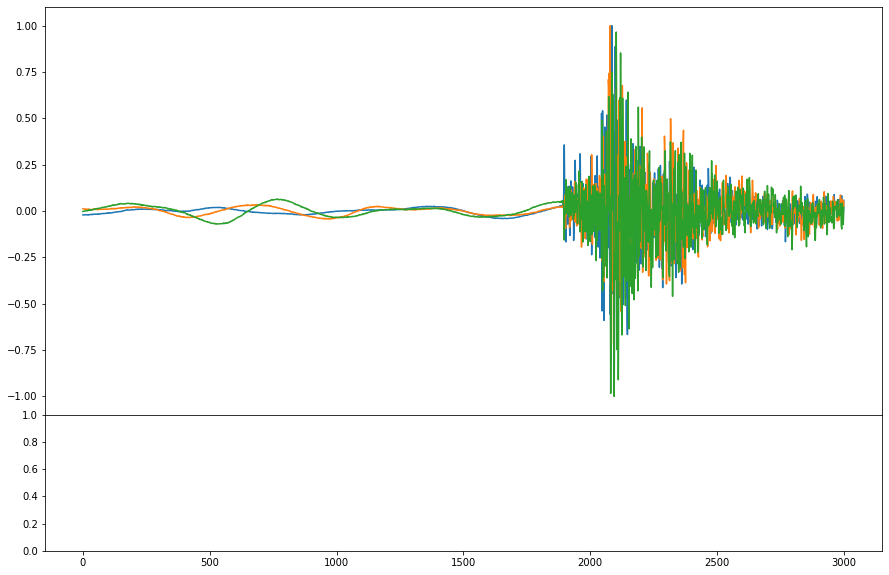

In [ ]:
sample = gen[np.random.randint(len(generator))]
sample
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
# axs[1].plot(sample["y"].T)

## Annotate Using Model

### Load Pretrained Models

Load EQTransformer trained on the ETHZ dataset

**Edit**: Tentatively commented out. Not using EQTransformer for this first check. Must have a random window of 60 seconds

In [ ]:
# pretrained_weights = sbm.EQTransformer.list_pretrained(details=False)
# print('EQTransformer pretarained keys', pretrained_weights)
# assert 'ethz' in pretrained_weights
# eq_transformer_model = sbm.EQTransformer.from_pretrained("ethz")

Load Phasenet trained on the ETHZ dataset

**Note**: Must have a random window of 30 seconds  ???

In [ ]:
pretrained_weights = sbm.PhaseNet.list_pretrained(details=False)
print('Phasenet pretarained keys', pretrained_weights)
assert 'ethz' in pretrained_weights
phasenet_model = sbm.PhaseNet.from_pretrained("ethz")
phasenet_model.eval()

Phasenet pretarained keys ['ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'scedc', 'stead']


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
  (in_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1dSame(
    (conv): Conv1d(8, 11, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1dSame(
    (conv): Conv1d(11, 16, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1dSame(
    (conv): Conv1d(16, 22, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd3): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1dSame(
    (conv): Conv1d(22, 32, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up1): ConvTranspose1d(32, 22, kernel_size=(7,), stride=(4,), padding=(2,))
  (bnu1): Batc

## Inference using models
**Note**: EQTransformer must have 6000 window length. Not used for now

shape torch.Size([3, 3001])
shape afetr unsqueeze torch.Size([1, 3, 3001])


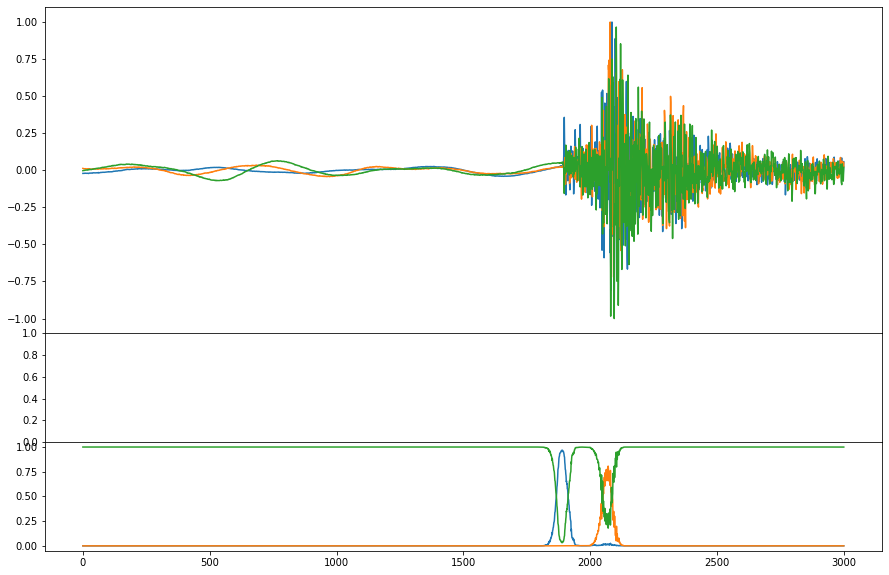

In [ ]:
fig = plt.figure(figsize=(15, 10))
models = [phasenet_model]#[phasenet_model, eq_transformer_model]
num_models = len(models)
height_ratios = [3,1] + [1] * num_models
axs = fig.subplots(2 + num_models, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": height_ratios})
axs[0].plot(sample["X"].T)
# axs[1].plot(sample["y"].T)
model_num = 1
with torch.no_grad():
  for model in models:
    model_num += 1
    tensor  = torch.tensor(sample["X"], device=model.device)
    print('shape', tensor.shape)
    tensor = tensor.unsqueeze(0)
    print('shape afetr unsqueeze', tensor.shape)
    pred = model(tensor)  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()
    axs[model_num].plot(pred.T)

## Residual Calculation

Some assumptions here: Need to check ???
 - Channel 0 in 'y' is P and channel 1 is 'S' 
 - btw what is channel 3?
 - Decide on phase type based on residual actually can be based on onset label if it is nonzero 
  -  

In [ ]:
predicted_onset_score =  np.max(pred[0])
predicted_onset = np.argmax(pred[0])
onset =  sample['onset_sample']  #np.argmax(sample['y'][0].squeeze())
residual_p = predicted_onset - onset
phase = 'P'
residual = residual_p
residual_p, onset

(-5.5, 1894.5)

In [ ]:
predicted_onset_score =  np.max(pred[1])
predicted_onset = np.argmax(pred[1])
onset = sample['onset_sample']  #np.argmax(sample['y'][1].squeeze())
residual_s = predicted_onset - onset
if residual_p > residual_s:
  phase='S'
  residual = residual_s
residual_s, onset

(176.5, 1894.5)

In [ ]:
residual_time = residual / 100
phase, residual, residual_time

('P', -5.5, -0.055)

## SNR calculations

*The following describes the calculation of the trace SNR as we have achieved in the informal morning  meeting with Joachim, Jannes, Guy and Moshe.*


Take 30s before the pick  and about 5 seconds after the pick. There are datasets where before the pick the signal is almost clear. We take 30s before the pick in order to have representative noise but avoid other seismic event that might occur before the main event  . The SNR is calculated  using
$$SNR = \frac{E_{S}}{E_{N}}$$
where
$$ E_{N}= \frac{1}{30} \int\limits_{t_{0}-30}^{t_{0}}v^{2}(\tau)d\tau, E_{S} \approx \frac{1}{5} \int\limits_{t_{0}}^{t_{0}+5}v^{2}(\tau)d\tau$$
**Note**: The above calculation is merely an approximation because the signal sample naturally  contains noise. But this is the best we can do and for large SNR scenarios it is a good estimation. Since we are looking for traces with high SNRs this estimate is good enough.


In practice the we have random crops such that times before and after events are not exactly 30 and 5 but as stated there exists at least 23 sec before and at least 3 seconds after the event.

Channels - which channel should I take? Mean? ???  For now the code uses a single channel

**P phase - take channel 0**

**S phase take the mean of channels 1 and 2**

In [ ]:
import math
def calc_snr(trace, onset):
  En = np.mean(np.square(trace[:onset])) 
  Es = np.mean(np.square(trace[onset:]))
  return Es / En

def to_db(snr):
  return math.log10(snr) * 10
def from_db(snr_db):
  return 10 ** (snr_db / 10)

print(from_db(20))

phase = 'P' 

onset =  sample['onset_sample'] # np.argmax(sample['y'][0].squeeze())
if onset == 0:
  phase = 'S'
  onset = sample['onset_sample'] # np.argmax(sample['y'][1].squeeze())
assert onset > 0, 'No onset'

# P phase - take channel 0
# if it is S take the mean of channels 1 and 2
samp_channel = sample["X"][0].squeeze() if phase=='P' else np.mean(sample['X'][1:], axis=0)
SNR = calc_snr(samp_channel, int(onset))  
phase, SNR, to_db(SNR), 'This sample should be filtered out' if to_db(SNR) < 10 else 'High SNR. Keep sample'

100.0


('P', 82.54832, 19.16708223033559, 'High SNR. Keep sample')

In [ ]:
def snr_to_factor(clean_snr, noise_energy, desired_snr):
  ratio = desired_snr / clean_snr
  return noise_energy / ratio
snr_to_factor(20, 5, 10)


10.0

## Batch Processing

After understanding the calculations needed to be done, this section will apply these calculations to a subset of the ETHZ dataset and look for a suitable subsubset s.t. the residual is low and the SNR is high. The term *batch* might confuse here. There is only one batch - the whole subset examined. As discussed in our meeting there is no need for a large subset because it is not used for training and given a suitable subsubset it can beaugmented to a large enough set for our noisy evaluations.

Contants used in this section:

**Note** we have decided to filter out by SNR and not by residuals. 
We shall see the residuals degrading based on noise level added.

In [ ]:
batch_size = 20
residual_threshold = 100.0  #  Do not use for now Seek for residuals below this threshold
SNR_threshold = 10     # 10 dB Seek for SNRs above this threshold
noise_sample_length = 100

In [ ]:
def eval_batch(batch, model):
  with torch.no_grad():
    pred = model(batch)  
    pred = pred.cpu()
  return pred
  

Results here looks strange ??? :

It was due to that I did not check what phase the samples are.

 - calc both residuals and take the minimum ?

In [ ]:
loader = DataLoader(gen, batch_size=batch_size, shuffle=False, num_workers=2)
batch = next(iter(loader))
pred_probs = eval_batch(batch['X'], phasenet_model)
pred = torch.argmax(pred_probs[:,0], axis=1)
onset_label = batch['onset_sample'] #torch.argmax(batch['y'][:,0].squeeze(), axis=1)
print('original onset labels', onset_label)
onset_label = onset_label.int()# Why arent the onset labels integers ???
residual = pred - onset_label
pred, onset_label, residual 


original onset labels tensor([1090.6000, 1680.5000, 1844.6000, 1879.0000, 1762.5000, 1336.5000,
        1829.0000, 1484.5000, 1620.5000, 1492.0000, 1578.6000, 1851.5000,
        1820.5000, 1289.0000, 1642.0000, 1607.5000, 1537.5000, 1759.0000,
        1507.5000, 1790.6000], dtype=torch.float64)


(tensor([1135, 1680, 1836, 1860, 1753, 1329, 1832, 1480, 1620, 1489, 1576, 1853,
         1752, 1208, 1560, 1528, 1541, 1765, 1508, 1791]),
 tensor([1090, 1680, 1844, 1879, 1762, 1336, 1829, 1484, 1620, 1492, 1578, 1851,
         1820, 1289, 1642, 1607, 1537, 1759, 1507, 1790], dtype=torch.int32),
 tensor([ 45,   0,  -8, -19,  -9,  -7,   3,  -4,   0,  -3,  -2,   2, -68, -81,
         -82, -79,   4,   6,   1,   1]))

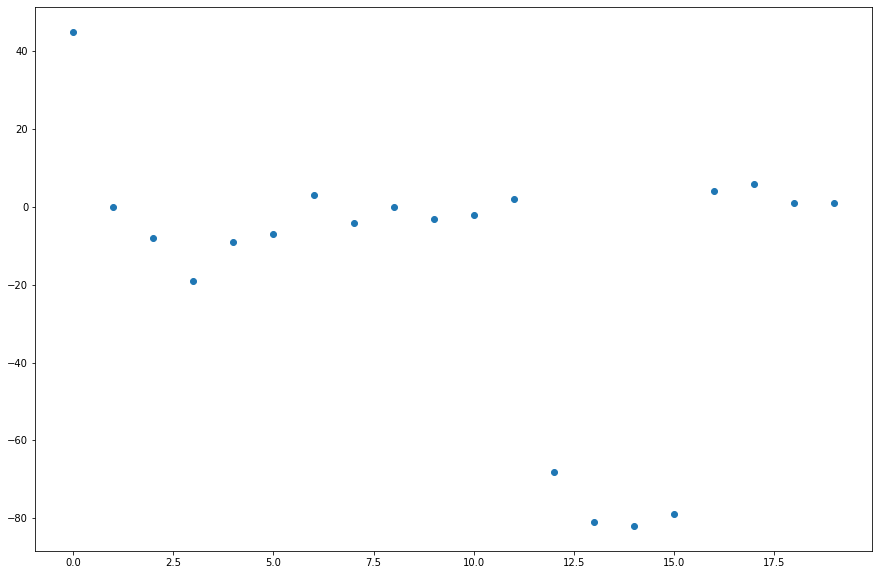

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(range(batch_size), residual);

In [ ]:
# from numpy.lib.stride_tricks import as_strided

# def take_per_row_strided(A, indx, num_elem=2):
#     m,n = A.shape
#     # A.shape = (-1)
#     A.reshape(-1)
#     s0 = A.strides[0]
#     l_indx = indx + n*np.arange(len(indx))
#     out = as_strided(A, (len(A)-num_elem+1, num_elem), (s0,s0))[l_indx]
#     A.shape = m,n
#     return out

In [ ]:
def calc_snr_batch(batch, onsets):
  batch_SNR = []
  # Sequential implementation till I find a nice way to slice with different indices
  for i in range(batch.shape[0]):
    trace = batch[i]
    onset = int(onsets[i])
    En = torch.mean(torch.square(trace[:onset])) 
    Es = torch.mean(torch.square(trace[onset:]))
    batch_SNR.append(float(to_db(Es / En)))
  return batch_SNR

traces = batch['X'][:,0]
# print(traces.shape)


SNR = calc_snr_batch(traces, pred)
SNR =  np.array(SNR)
high_SNR_samples = np.argwhere(SNR > SNR_threshold)
print(f'SNR values in batch {SNR} ')
print(f'There are {len(high_SNR_samples)} samples with high SNRs')
print (f'Samples with high SNRs {high_SNR_samples.T}') 
print(f'The high SNRs {SNR[high_SNR_samples].T}')

SNR values in batch [ 3.43553375 -3.4553275   3.44645023 18.70149368  1.45160035 -6.37555341
 -2.00968264  6.99360686 -2.17125215 -4.09839172 10.53840195  4.03536948
 12.4308822   7.9990758  14.51993726  5.86182532 27.79924405 10.62158501
 11.76839885  6.79369815] 
There are 7 samples with high SNRs
Samples with high SNRs [[ 3 10 12 14 16 17 18]]
The high SNRs [[18.70149368 10.53840195 12.4308822  14.51993726 27.79924405 10.62158501
  11.76839885]]


## Filter Traces

### Filter By SNR

In [ ]:
t_SNR = torch.LongTensor(SNR)

traces_with_high_SNR = traces[t_SNR > SNR_threshold, :]

(t_SNR > SNR_threshold).nonzero().T, traces_with_high_SNR.shape, batch['X'][t_SNR > SNR_threshold, :].shape

(tensor([[ 3, 12, 14, 16, 18]]),
 torch.Size([5, 3001]),
 torch.Size([5, 3, 3001]))

### Filter By Residual

We are not going to use that for now

In [ ]:
t_residual = torch.LongTensor(residual)

traces_with_low_residual = traces[t_residual < residual_threshold, :]

(t_residual < residual_threshold).nonzero().T, traces_with_low_residual.shape

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19]]), torch.Size([20, 3001]))

##Add noise

In [ ]:
noisy_traces = torch.clone(batch['X'][t_SNR > SNR_threshold, :])
noise_sample = noisy_traces[:, :,:noise_sample_length]
noise = torch.from_numpy(noise_trace) #torch.cat([noise_sample] * int(noisy_traces.shape[-1] / noise_sample_length) , dim=2)
noisy_traces.shape, noise_sample.shape ,noise.shape
# noisy_traces.shape, noise_sample.shape ,noise.shape

(torch.Size([5, 3, 3001]), torch.Size([5, 3, 100]), torch.Size([3, 3001]))

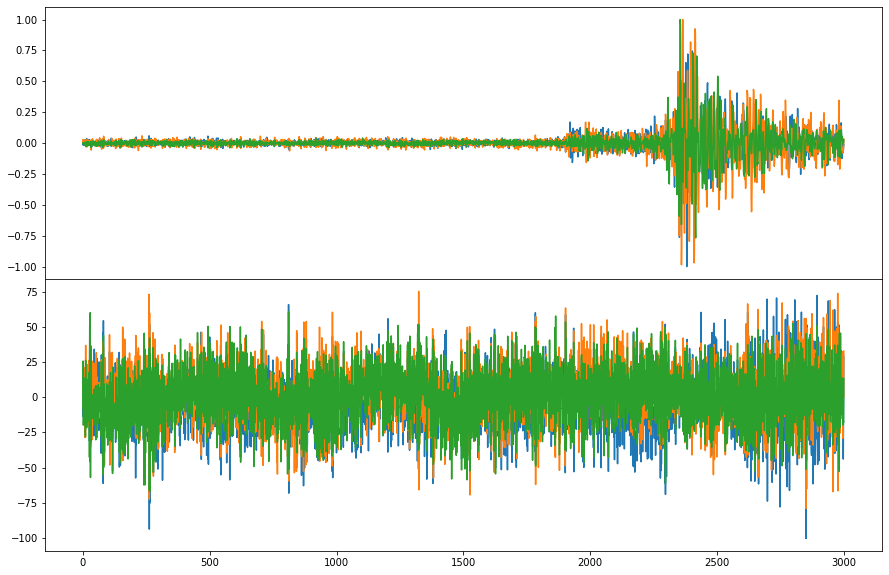

In [ ]:
noise_factor = 10.0


fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2 , 1, sharex=True, gridspec_kw={"hspace": 0})
axs[0].plot(noisy_traces[0].T)
noisy_traces += (noise_factor * noise)
axs[1].plot(noisy_traces[0].T)

##Predict noisy traces

In [ ]:
clean_pred_probs = eval_batch(batch['X'][t_SNR > SNR_threshold, :], phasenet_model)
noisy_pred_probs = eval_batch(noisy_traces, phasenet_model)

In [ ]:
clean_pred = torch.argmax(clean_pred_probs[:,0], axis=1)
noisy_pred = torch.argmax(noisy_pred_probs[:,0], axis=1)

onset_label = batch['onset_sample'][t_SNR > SNR_threshold] 
clean_residual = clean_pred - onset_label

noisy_residual = noisy_pred - onset_label

clean_residual , noisy_residual


(tensor([-19.0000, -68.5000, -82.0000,   3.5000,   0.5000], dtype=torch.float64),
 tensor([-1858.0000, -1799.5000, -1621.0000, -1516.5000, -1486.5000],
        dtype=torch.float64))

##Test Various SNRs For a Given Trace

onset 1879
0
18.695470949803706
0.01
14.863815533921493
0.02
10.673369569681315
0.03
8.010360584261175
0.04
6.279746544833183
0.05
5.111644585515011
0.06
4.297799257215619
0.07
3.714963488961259
0.08
3.287170583835444
0.09
2.9661300101372428
tensor([1860, 1859, 1891, 1896, 1907, 1912, 1912, 1912, 1924, 1925]) tensor([-19, -20,  12,  17,  28,  33,  33,  33,  45,  46])


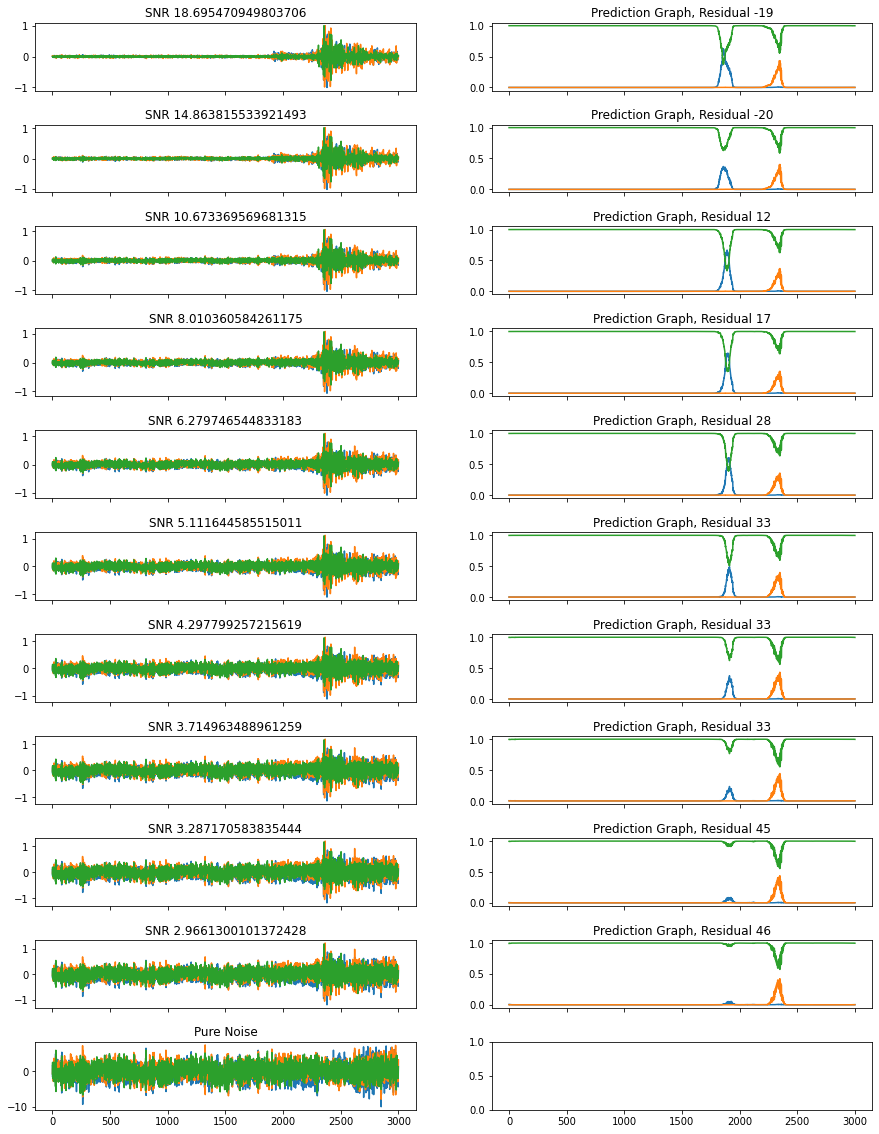

In [ ]:
trace_idx = 0
num_of_levels = 10
high_SNR_traces = torch.clone(batch['X'][t_SNR > SNR_threshold, :])
assert high_SNR_traces.shape[0] > trace_idx, 'There is no such index in the high SNRs traces'
# clean_pred = torch.argmax(clean_pred_probs[trace_idx,0], axis=1)
onst = int(onset_label[trace_idx].int())
print('onset', onst)
plot_num = 0
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(num_of_levels + 1 , 2, sharex=True, gridspec_kw={"hspace": 0.5})
noisy_trcs = []
for f in range(num_of_levels):
  
  factor =   f * 0.01 if f > 0 else 0
  print(factor)
  trc = torch.clone(high_SNR_traces[trace_idx])
  trc += (factor * noise)
  noisy_trcs.append(trc)
  snr = calc_snr(trc[0].numpy(), onst)
  snr = to_db(snr)
  print(snr)
  axs[plot_num,0].plot(trc.T)
  axs[plot_num,0].title.set_text(f'SNR {snr}')
  plot_num+=1
  
axs[plot_num,0].plot(noise.T)
axs[plot_num,0].title.set_text(f'Pure Noise')
noisy_trcs_stacked = torch.stack(noisy_trcs)
noisy_preds = eval_batch(noisy_trcs_stacked, phasenet_model)
onst_preds = torch.argmax(noisy_preds[:,0], axis=1)
residuals = onst_preds - onst
print(onst_preds, residuals)
for i in range(num_of_levels):
  axs[i,1].plot(noisy_preds[i,:,:].T)
  axs[i,1].title.set_text(f'Prediction Graph, Residual {residuals[i]}')



## Test Various Factors

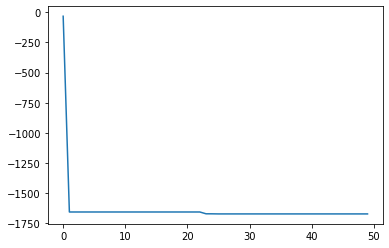

In [ ]:
residuallevels = []
clean_residual = torch.abs(clean_pred - onset_label)
clean_pred = torch.argmax(clean_pred_probs[:,0], axis=1)

for factor in range(50):
  noisy_traces = torch.clone(batch['X'][t_SNR > SNR_threshold, :])
  noise_sample = noisy_traces[:, :,:noise_sample_length]
  # noise = torch.cat([noise_sample] * int(noisy_traces.shape[-1] / noise_sample_length) , dim=2)
  noisy_traces += (factor * noise)
  noisy_pred_probs = eval_batch(noisy_traces, phasenet_model)
  noisy_pred = torch.argmax(noisy_pred_probs[:,0], axis=1)
  noisy_residual = noisy_pred - onset_label
  residuallevels.append(torch.mean(noisy_residual.float()))
  # residuallevels.append(torch.mean(torch.abs(clean_residual.float() - noisy_residual.float())))

plt.plot(residuallevels)

# TODO
 - Save first 3000 sample of ETHZ dataset (and generally every    dataset) as noise. Do not concatenate noise
 - Use steered generator with custom augmentation to generate fixed windows for eveluation.
 - seperate windowing for SNR calculations ???
 - plots:
    - seperate plot for each  trace
    - residual vs trace SNR - do not abs residual and use SNR as X instead of noise factor
    - join traces plots using plot opacity
    - align SNR axis linearly and logarithmically (separate plots)
    - plot the whole distribution vs SNR

- Complete batche calculation for SNR
- ~~Filter for the right event and compute SNRs using the relevant channel~~
-  ~~Take traces above SNR threshold~~
- ~~Take traces below residual threshold~~ not to be done
- ~~ Add a factor of noise before event to all trace~~
- ~~results for various factors - residual ??? ~~

In [ ]:
;